In [83]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import shap
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
import keras
from livelossplot import PlotLossesKeras
import eli5
from eli5.sklearn import PermutationImportance
import scipy
from scipy.cluster import hierarchy as hc
from pdpbox import pdp, get_dataset, info_plots
from lime.lime_tabular import LimeTabularExplainer
import math

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


shap.initjs()


label_column = "loan"
csv_path = 'data/adult.data'
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]
input_columns = ["age", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]
categorical_features = ["workclass", "education", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

def prepare_data(df):
    
    if "fnlwgt" in df: del df["fnlwgt"]
    
    tmp_df = df.copy()

    # normalize data (this is important for model convergence)
    dtypes = list(zip(tmp_df.dtypes.index, map(str, tmp_df.dtypes)))
    for k,dtype in dtypes:
        if dtype == "int64":
            tmp_df[k] = tmp_df[k].astype(np.float32)
            tmp_df[k] -= tmp_df[k].mean()
            tmp_df[k] /= tmp_df[k].std()

    cat_columns = tmp_df.select_dtypes(['object']).columns
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('category')
    tmp_df[cat_columns] = tmp_df[cat_columns].apply(lambda x: x.cat.codes)
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('int8')
    
    return tmp_df

def get_dataset_1():
    tmp_df = df.copy()
    tmp_df = tmp_df.groupby('loan') \
                .apply(lambda x: x.sample(100) if x["loan"].iloc[0] else x) \
                .reset_index(drop=True)
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    return tmp_df, df_display.copy()

def get_production_dataset():
    tmp_df = df.copy()
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

    return X_valid, y_valid


def get_dataset_2():
    tmp_df = df.copy()
    tmp_df_display = df_display.copy()
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    X_display = tmp_df_display.drop(label_column, axis=1).copy()
    y_display = tmp_df_display[label_column].astype(int).values.copy()
    
    X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

    return X, y, X_train, X_valid, y_train, y_valid, X_display, y_display
    
df_display = pd.read_csv(csv_path, names=csv_columns)
df_display[label_column] = df_display[label_column].apply(lambda x: ">50K" in x)
df = prepare_data(df_display)

def build_model():
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(df[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs):
    """Convert probabilities into classes"""
    return list((probs >= 0.5).astype(int).T[0])

def plot_roc(y, probs):
    
    fpr, tpr, _ = roc_curve(y, probs)

    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.rcParams.update(params)
    plt.show()
    
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in list(np.logspace(0.6,4,dtype='int')):
        if m >= len(X_train): break
        model.fit(f_in(X_train,m), y_train[:m], epochs=50, batch_size=512, verbose=0)
        y_train_predict = model.predict(f_in(X_train,m))
        y_val_predict = model.predict(f_in(X_val))
        y_train_predict = f_out(y_train_predict)
        y_val_predict = f_out(y_val_predict)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    
def keras_score(self, X, y, **kwargs):
    """ Scorer class for eli5 library on feature importance"""
    input_test = [X[:,i] for i in range(X.shape[1])]
    loss = self.evaluate(input_test, y)
    if type(loss) is list:
        # The first one is the error, the rest are metrics
        return -loss[0]
    return -loss

class ModelWrapper():
    """ Keras model wrapper to override the predict function"""
    def __init__(self, model):
        self.model = model
    
    def predict(self, X, **kwargs):
        return self.model.predict([X.iloc[:,i] for i in range(X.shape[1])])


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Explainability and Bias Evaluation<br> with Tensorflow</font></h1> 

<br>
<br>
<br>
<br>
<br>
<br>

<h1>Alejandro Saucedo</h1>
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning

<br>
<br>

[github.com/ethicalml/bias-analysis](github.com/ethicalml/bias-analysis)


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">NEW Project!</font></h1> 

<br>
<br>
<br>

## Client wants to automate loan approval process

<br>

#### They have a manual process where a domain expert goes through applicants
They want to automate this as they get 1m requests per month

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Business wants it NOW!</font></h1>

<br>
<br>

## Or yesterday if possible...

<br>
<br>

They heard their competitor is using "Machine Learning" and business says we need to use that

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">We asked for DATA</font></h1> 

<br>
<br>

## They gave us an excel sheet with 25 rows

<br>
<br>

We pushed back, and after a while we finally got a dataset with ~8000 rows

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">And so it begun...</font></h1> 

<img src="images/copypasta.jpg" style="height:50vh">

<br>
<br>

## The journey towards greatness...

In [84]:
df_data, df_display = get_dataset_1()

df_display.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


In [85]:
X = df_data.drop(label_column, axis=1).copy()
y = df_data[label_column].astype(int).values.copy()

X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

X_train.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country
4532,1.276965,4,9,1.134721,6,8,1,4,0,-0.145918,-0.216656,-0.035429,39
11847,2.596571,4,3,-3.140908,2,14,0,2,1,-0.145918,-0.216656,-1.655199,39
16245,2.963128,4,9,1.134721,2,12,0,4,1,-0.145918,-0.216656,-0.035429,39
11203,2.083391,2,12,1.523415,0,1,1,4,0,0.126109,-0.216656,-0.035429,39
19215,-1.069002,4,11,-0.420053,4,14,4,2,1,-0.145918,-0.216656,-0.035429,39


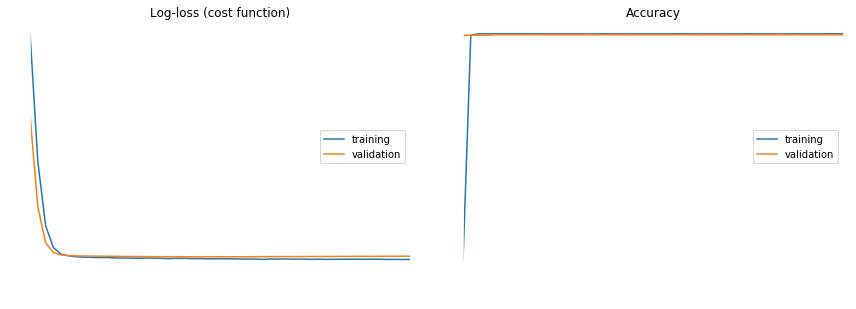

Log-loss (cost function):
training   (min:    0.019, max:    0.574, cur:    0.019)
validation (min:    0.025, max:    0.372, cur:    0.027)

Accuracy:
training   (min:    0.796, max:    0.996, cur:    0.996)
validation (min:    0.995, max:    0.995, cur:    0.995)


In [86]:
# 1 layer, 100 neurons model, with softmax
model = build_model()

model.fit(f_in(X_train), y_train, epochs=50,
    batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid),
    callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)

In [87]:
score = model.evaluate(f_in(X_valid), y_valid, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

4964/4964 [==============================] - 0s 14us/step
Error 0.0267: 
Accuracy 99.5367: 


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">It's PROD-TIME!</font></h1> 

<br>
<br>
<br>
<br>

### Accuracy is 98% - How lucky are we!

<br>
<br>
<br>

##### Press the button?


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">2am emergency call...</font></h1> 


...what do you mean performing terrible? We followed the instructions!

<br>

<img src="images/layer.jpg" style="height: 50vh">


<br>


# Time to REVERT!



In [88]:
X_prod, y_prod = get_production_dataset()

score = model.evaluate(f_in(X_prod), y_prod, verbose=1)

print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

6513/6513 [==============================] - 0s 15us/step
Error 1.0346: 
Accuracy 76.5546: 


In [89]:
probabilities = model.predict(f_in(X_valid))
print(list(probabilities.T[0])[:10])

pred = f_out(probabilities)
print(pred[:10])

[0.00011620388, 3.9572033e-06, 6.058631e-07, 1.9598474e-05, 0.00024959588, 0.0035704444, 0.0022090233, 2.3400333e-05, 0.005773348, 7.921332e-05]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


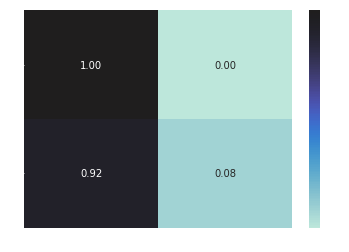

In [90]:
confusion = sklearn.metrics.confusion_matrix(y_valid, pred)
confusion_scaled = confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
confusion_scaled_df = pd.DataFrame(confusion_scaled, index=["Denied", "Approved"], columns=["Denied", "Approved"])
sn.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)

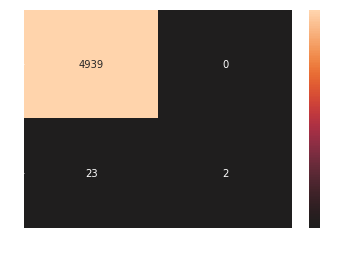

In [91]:
confusion_df = pd.DataFrame(confusion,
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)

In [92]:
print(sklearn.metrics.classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4939
           1       1.00      0.08      0.15        25

   micro avg       1.00      1.00      1.00      4964
   macro avg       1.00      0.54      0.57      4964
weighted avg       1.00      1.00      0.99      4964



0.54


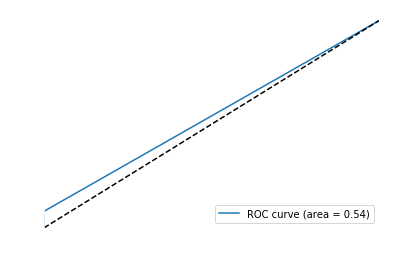

In [93]:
plot_roc(y_valid, pred)

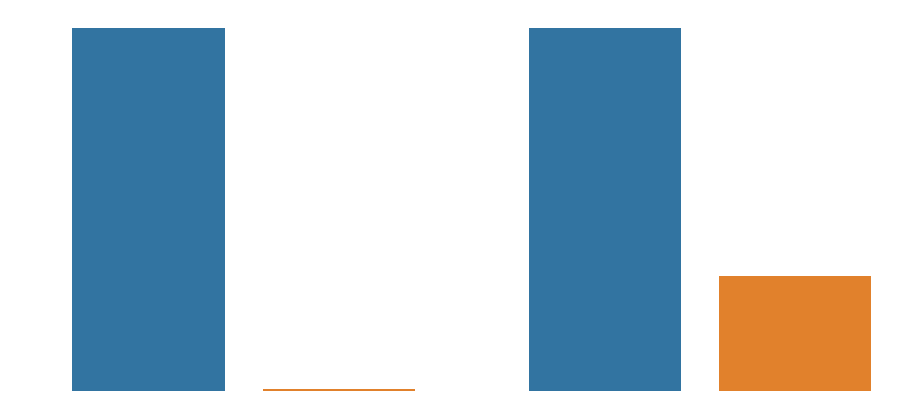

In [94]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sn.countplot(y_valid, ax=ax[0]) 
sn.countplot(y_prod, ax=ax[1]) 

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Bias</font></h1>

<br>
<br>
<br>
<br>

Any non trivial decision (i.e. more than 1 option) holds a bias, without exceptions.


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Defining bias for our context</font></h1>

<br>
<br>
<br>

## Constraints bias (bias a-priori)

* The constraints and limits that are imposed around the delivery

<br>
<br>
<br>

## Statistical bias (bias a-posteriori)

In [ ]:
X, y, X_train, X_valid, y_train, y_valid, X_display, y_display \
    = get_dataset_2()
X.head()

# Learning curves

In [ ]:
plot_learning_curves(model, X_valid, y_valid)

# Data Analysis

In [ ]:
X_analysis = X_display.copy()
y_analysis = y_display.copy()
df_analysis = X_analysis.copy()
df_analysis[label_column] = y_analysis

In [ ]:
df[label_column].value_counts().plot.barh()

In [ ]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(X.shape[1]) / cols)
for i, column in enumerate(X.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if X.dtypes[column] == np.object:
        X[column].value_counts().plot(kind="bar", axes=ax)
    else:
        X[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [ ]:
df["gender"].value_counts().plot.barh()

In [ ]:
flds = ["gender", "age", "education-num", "capital-gain", 
                  "capital-loss", "hours-per-week"]


enc_summ = X_display[flds].groupby("gender", as_index=False).mean()
enc_summ

In [ ]:
df["ethnicity"].value_counts().plot.barh()

In [ ]:
perm = PermutationImportance(model, random_state=1, scoring=keras_score).fit(X,y)

In [ ]:
eli5_fi = eli5.explain_weights_df(perm, feature_names = X.columns.tolist())
eli5_fi

In [ ]:
eli5_fi.plot("feature", "weight", "barh", figsize=(12,7))

In [ ]:
df.groupby(["marital-status", "loan"]).size().plot("barh")

# Sit down with our clients to understand these perspectives

In [ ]:
def plot_dendogram(corr):
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method="average")
    fig = plt.figure(figsize=(16,5))
    dendrogram = hc.dendrogram(
        z, labels=X_analysis.columns, orientation="left", leaf_font_size=16)
    plt.show()

In [ ]:
corr = np.round(scipy.stats.spearmanr(X_analysis).correlation, 4)
plot_dendogram(corr)

# Partial dependence

In [ ]:
df_analysis.plot(
    "age", 
    "capital-gain",
    "scatter",
    alpha=0.01,
    figsize=(10,8))

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=df, feature="age", feature_name="age", target="capital-gain")

In [ ]:
mr = ModelWrapper(model)
    
fig, axes, summary_df = info_plots.actual_plot(
    model=mr, X=X, feature="gender", feature_name="gender", predict_kwds={})

In [ ]:
pdp_sex = pdp.pdp_isolate(
    model=mr, dataset=X, model_features=input_columns, feature='gender'
)

fig, axes = pdp.pdp_plot(pdp_sex, 'gender')

# SHAP

In [99]:
def shap_predict(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values

shap_explainer = shap.KernelExplainer(shap_predict, X.iloc[:100,:])

In [100]:
shap_idx = 0
shap_x = X.iloc[shap_idx,:]
shap_display_x = X_display.iloc[shap_idx,:]
shap_values = shap_explainer.shap_values(shap_x, nsamples=500)

Probability:  [0.0001162]


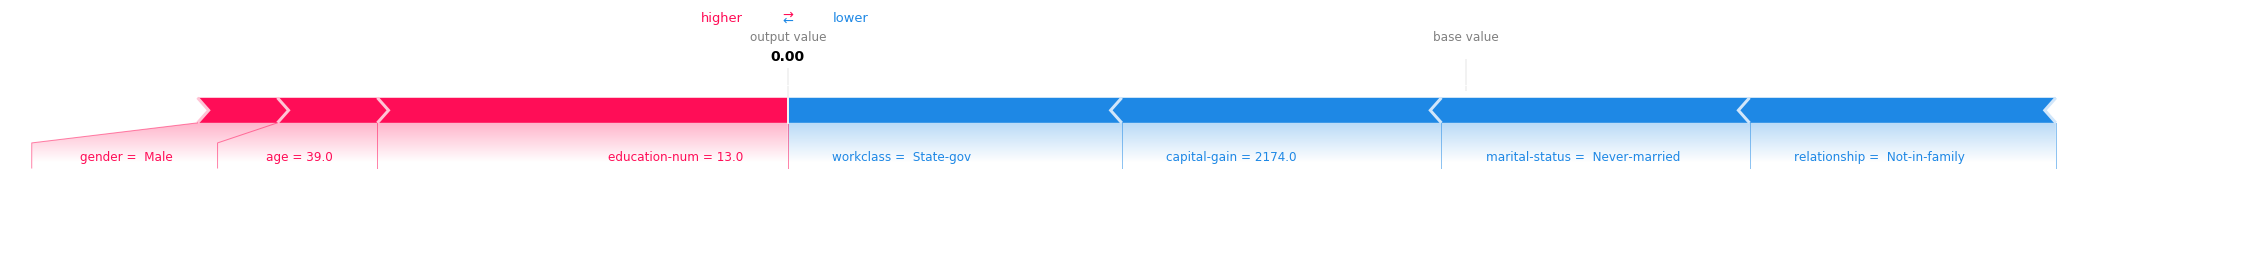

In [101]:
print("Probability: ", probabilities[shap_idx])
shap.force_plot(shap_explainer.expected_value, shap_values, shap_display_x, matplotlib=True, figsize=(40, 3))

In [102]:
shap_idx_multi_from = 15
shap_idx_multi_to = 40

shap_x_multi = X.iloc[shap_idx_multi_from:shap_idx_multi_to,:]
shap_display_multi = X_display.iloc[shap_idx_multi_from:shap_idx_multi_to,:]
shap_y_multi = y[shap_idx_multi_from:shap_idx_multi_to]

In [103]:
shap_values_multi = shap_explainer.shap_values(shap_x_multi, nsamples=500)

100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


In [104]:
shap.force_plot(shap_explainer.expected_value, shap_values_multi, shap_display_multi)

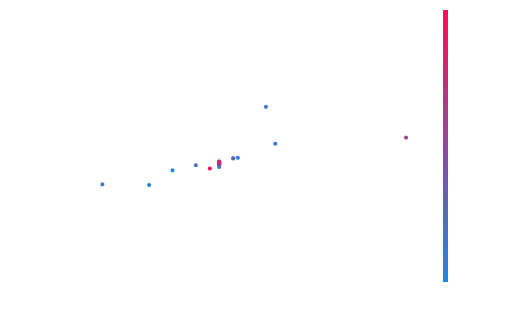

In [105]:
shap.dependence_plot("hours-per-week", 
                     shap_values_multi, 
                     shap_x_multi, 
                     display_features=shap_display_multi,
                     axis_color='#FFFFFF')

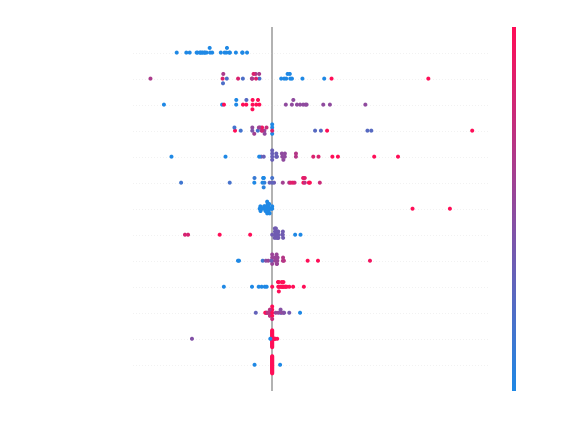

In [106]:
shap.summary_plot(shap_values_multi, shap_x_multi, axis_color='#FFFFFF')

# Lime

In [95]:
tf_lime_explainer = LimeTabularExplainer(
                X_train.values,
                feature_names=list(X_train.columns),
                categorical_features=categorical_features)

In [96]:
def lime_predict_proba(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    prob_pairs = np.array([1-values, values]).T
    return prob_pairs

tf_lime_explanation = tf_lime_explainer.explain_instance(
        X_train.iloc[1,:], lime_predict_proba, num_features=13) 

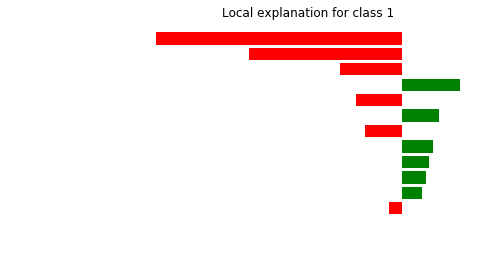

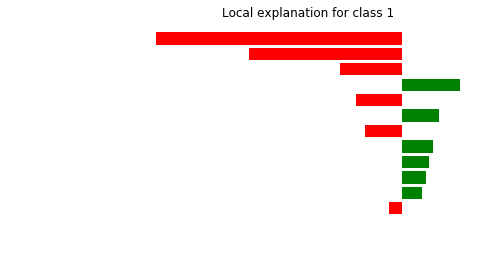

In [97]:
tf_lime_explanation.as_pyplot_figure()

In [98]:
tf_lime_explanation.show_in_notebook(show_table=True, show_all=True)